# Exploring Google AudioSet
## Anna Bernbaum
### 2019

In [19]:
import tensorflow as tf
import numpy as np
import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# tf.enable_eager_execution()

# Sources
Based on:
https://github.com/ganesh-srinivas/audioset-tutorial


# Pre-requisites:
This notebook relies on the following data-sources, remember to download them before beginnning:
- [balanced_train_segments.csv](http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/balanced_train_segments.csv)
- [unbalanced_train_segments.csv](http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/unbalanced_train_segments.csv)
- [eval_segments.csv](http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/eval_segments.csv)
- [128-dimension audio features](http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/features/features.tar.gz) i.e., embeddings - About 2GB in size.
- [class_labels_indices.csv](http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv)

# Data Exploration

`examples` must contain YouTube IDs of all examples for one class. Consider the class `Cough`.

Let's find the index and code associated with 'Cough':

In [2]:
class_label_index = !grep Cough AudioSet/class_labels_indices.csv
print(class_label_index)

['47,/m/01b_21,"Cough"']


Retreiving the class label:

In [3]:
print(class_label_index[0].split(",")[1])

/m/01b_21


Finding all samples with the selected label. The header of this table is printed.

In [4]:
!grep /m/01b_21 AudioSet/balanced_train_segments.csv |head  # ID manually inserted

1PajbAKd8Kg, 0.000, 10.000, "/m/01b_21"
1e3_ucOz0Ik, 20.000, 30.000, "/m/01b_21,/m/09x0r,/m/0dl9sf8,/m/0ytgt"
1jc3YPwYfC4, 220.000, 230.000, "/m/01b_21,/m/09x0r"
2I2IzXnhmtc, 120.000, 130.000, "/m/01b_21"
2ZfwEg4JaiU, 0.000, 10.000, "/m/01b_21,/m/04rlf,/m/09x0r"
4EiskLYtkO4, 0.000, 10.000, "/m/01b_21"
4WLF2CT0eCM, 40.000, 50.000, "/m/01b_21"
58jMS3K5iMo, 130.000, 140.000, "/m/01b_21,/m/04rlf,/m/09x0r"
8N5XxcJ7QOU, 20.000, 30.000, "/m/01b_21,/m/04rlf,/m/07yv9,/m/09x0r,/m/0dl9sf8,/m/0k4j"
8l8ghk2CDbE, 190.000, 200.000, "/m/01b_21,/m/09x0r"


Extracting the associated YouTubeIDs from all of the selected samples. This is done by removing the times and keys.

In [5]:
examples = !grep /m/01b_21 AudioSet/balanced_train_segments.csv | head -10 | cut -c -11
print(examples)

['1PajbAKd8Kg', '1e3_ucOz0Ik', '1jc3YPwYfC4', '2I2IzXnhmtc', '2ZfwEg4JaiU', '4EiskLYtkO4', '4WLF2CT0eCM', '58jMS3K5iMo', '8N5XxcJ7QOU', '8l8ghk2CDbE']


Extracting the prefix of each of the selected YouTubeIDs

In [6]:
tfrecord_prefixes = set([i[:2] for i in examples])
print(tfrecord_prefixes)

{'1j', '4E', '1P', '4W', '8N', '1e', '2Z', '2I', '58', '8l'}


The filenames of each selected clip are constructed in order to find their associated `tfrecords`

In [7]:
tfrecord_filenames = ["AudioSet/features_us/bal_train/" + i + ".tfrecord" for i in tfrecord_prefixes]  
print(tfrecord_filenames)

['AudioSet/features_us/bal_train/1j.tfrecord', 'AudioSet/features_us/bal_train/4E.tfrecord', 'AudioSet/features_us/bal_train/1P.tfrecord', 'AudioSet/features_us/bal_train/4W.tfrecord', 'AudioSet/features_us/bal_train/8N.tfrecord', 'AudioSet/features_us/bal_train/1e.tfrecord', 'AudioSet/features_us/bal_train/2Z.tfrecord', 'AudioSet/features_us/bal_train/2I.tfrecord', 'AudioSet/features_us/bal_train/58.tfrecord', 'AudioSet/features_us/bal_train/8l.tfrecord']


Next, we are able to create 2 dictionaries:
1. `audio_embeddings_dict` - A dictionary containing the audio data for all selected clips
2. `audio_labels_dict` - A dictionary containing the YouTubeIDs of all selected clips

In [8]:
audio_embeddings_dict = {}
audio_labels_dict = {}
#all_tfrecord_filenames = glob.glob("bal_train/" + example[:2] + ".tfrecord")

# Load embeddings
sess = tf.Session() # create TensorFlow Session
for tfrecord in tfrecord_filenames: 
    for example in tf.python_io.tf_record_iterator(tfrecord):  # iterator that reads record from a tfrecords file
        tf_example = tf.train.Example.FromString(example)  # decode message
#         print(tf_example)
        
        # extract YouTubeID
        vid_id = tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8')
        
        if vid_id in examples:  # for the selected Example ID

            # PROBLEM: WHY ARE ONLY 5 OF THE 10 CLIPS COMING THROUGH
            # Could this be a difference between the EU and US datasets?  -tested, no

            # Extract the indices of the sounds contained in each clip
            example_label = list(np.asarray(tf_example.features.feature['labels'].int64_list.value))  
            
            # specify the structure of your data
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            
            # length of each sample (10 seconds)
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            
            audio_frame = []
            for i in range(n_frames):  # for each second of audio
                audio_frame.append(tf.cast(tf.decode_raw(
                     tf_seq_example.feature_lists.feature_list['audio_embedding'].feature[i].bytes_list.value[0],tf.uint8)
                    ,tf.float32).eval(session=sess))
                
            # creating a dictionary of the embedded audio, indexed by video ID    
            audio_embeddings_dict[vid_id] = audio_frame      
            
            # creating a dictionary of the sounds contained in each clip, indexed by video ID. 
            # Note that the cough index is 47
            audio_labels_dict[vid_id] = example_label
sess.close()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
print(audio_labels_dict)
print(audio_embeddings_dict)

# why are there only 5 here when 11 samples were selected

{'4EiskLYtkO4': [47], '1PajbAKd8Kg': [47], '1e3_ucOz0Ik': [0, 3, 47, 48], '2I2IzXnhmtc': [47], '58jMS3K5iMo': [0, 47, 137]}
{'4EiskLYtkO4': [array([139.,  87., 156., 127., 138.,  84., 124., 103., 255., 181.,  13.,
        92., 165., 122.,  15.,  26.,  50., 104., 147., 222.,  91.,  27.,
       226., 141.,   0., 226.,  20.,  58., 188.,   0.,  48., 162., 122.,
       177., 207., 132.,   0., 116., 202.,  69., 109., 118.,  79., 255.,
        70., 125.,   0., 255.,  68., 255., 168., 215., 232.,   0., 126.,
        82.,  16., 220.,   0., 162., 101.,   0., 218., 229.,   0.,  94.,
       107., 182., 102., 179., 228.,  86.,  78., 255., 227., 171., 187.,
       101., 255., 187.,   0., 173., 226., 110., 146.,  72., 169., 206.,
        49.,   0.,  70.,  44.,   0.,  53., 176., 132.,  75.,   0.,  89.,
         0.,  83., 151., 255., 216., 255., 135., 205., 133.,   0.,  78.,
       208.,  28., 255., 194.,   0., 127.,  89., 138.,   0.,  80.,   0.,
       232., 108.,   0., 209., 191., 255., 169.], dtype=

# The Data Structure

The data from Google's AudioSet is downloaded from 

http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/features/features.tar.gz 

as a `tar.gz` file. A tar file, often called a tarball, is a collection of files wrapped up in one single file for easy storage. When one is compressed, it gets the `tar.gz` file extension.

Within this file, when it has been unzipped, there are 3 folders:
- `bal_train`: In the balanced evaluation and training sets, Google's Audioset team strived for each class to have the same number of examples. 
- `unbal_train`: The unbalanced training set contains the remainder of annotated segments.
- `eval`: an evaluation dataset

Each of these folders contain numerous `.tfrecord` files. These are 'sharded' by the first 2 letters of the YouTubeIDs of each clip. Sharding simply means that all of the clips with an ID beginning with '5h', for example, are stored in the same `.tfrecord` file. 

Each `.tfrecord` file contains a `tensorflow.SequenceExample` protocol buffer for each audio clip that it contains. A `SequenceExample` has 2 attributes:
- `context` - this attribute expects type tf.train.Features. It contains information that is relevant for each of the features in the `feature_list` attribute. This dataset has 4 features:
    - `end_time_seconds`
    - `start_time_seconds`
    - `labels`
    - `video_id`
    
- `feature_lists` -  the type of this attribute is tf.train.FeatureLists. It contains lists of features, where each feature again is some kind of sequential data. In this case, it contains  bytes lists, each representing a single second of audio data. The key `audio_embedding` is used.



An example of one of these buffers, specifically the `1u` shard within the `bal_train` folder:

In [10]:
result_dict = {}
i = 0

for example in tf.python_io.tf_record_iterator("Audioset/features_eu/bal_train/1u.tfrecord"):
    result = tf.train.SequenceExample.FromString(example)
    result_dict[i] = result
    i = i + 1

print(result_dict[0])
print('Number of samples with YouTubeID beginning "1u":', len(result_dict))

context {
  feature {
    key: "end_time_seconds"
    value {
      float_list {
        value: 40.0
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 0
        value: 345
      }
    }
  }
  feature {
    key: "start_time_seconds"
    value {
      float_list {
        value: 30.0
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "1u_aTrPYpDY"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "audio_embedding"
    value {
      feature {
        bytes_list {
          value: "Po\206\036\261\203XU\264\215:\275\000\300\332\345\213W\331^\261}m8\016\377\207\377\323r\251\000{\313\023?\231\377<\000\352\275\243D\232h\377\362H\000\000\352\266\037\234\313\322B wZ*\377\273\377wkJ\377\000\362)\031a\240[o\207]7e\377\271\313]\377\236\262\274\377\352G\000\377\263n\000\351m\377\254p\002\000\000\000\305\306\266:\247N}M\032~\275\212\017\342v\351\007}\203\252,\373"
        }
      }
      feature {
   

# Reading from a TFRecord

Based on: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

## Function to print all information in a .tfrecord

In [11]:
def read_tfrecord(record):  # where record is a string such as 1u
    # Read TFRecord file
    record_iterator = tf.python_io.tf_record_iterator(path='Audioset/features_eu/bal_train/' + record + '.tfrecord')


    # find number of records
    n = 0
    for r in tf.python_io.tf_record_iterator(path='Audioset/features_eu/bal_train/' + record + '.tfrecord'):
        n += 1
    n = int(n)      


    print('\nThe Record '+ record + '.tfrecord contains %d clips:' %n)

    # Get information for each record
    i = 1
    for string_record in record_iterator:

        example = tf.train.Example()
        example.ParseFromString(string_record)

        end_time_seconds = int(example.features.feature['end_time_seconds']
                                     .float_list
                                     .value[0])

        start_time_seconds = int(example.features.feature['start_time_seconds']
                                    .float_list
                                    .value[0])

        j = 0
        labels = []
        for j in range(len(example.features.feature['labels'].int64_list.value)):
            # get each label as an int
            label = int(example.features.feature['labels']
                                      .int64_list
                                      .value[j])
            labels.append(label)
            j = j + 1



        video_id = (example.features.feature['video_id']
                                    .bytes_list
                                    .value[0]).decode("utf-8") 

        print('\n\nClip %d:\n' %i)
        print('Video ID:', video_id)
        print('Start Time:', start_time_seconds)
        print('End Time:', end_time_seconds)
        print('Labels:', labels)
        i = i + 1

Lets test it, insert any prefix of a YouTubeID, e.g. 1u

In [12]:
read_tfrecord('56')


The Record 56.tfrecord contains 9 clips:


Clip 1:

Video ID: 56qNZpiwRPw
Start Time: 30
End Time: 40
Labels: [469]


Clip 2:

Video ID: 56_1qrWVNIw
Start Time: 430
End Time: 440
Labels: [387]


Clip 3:

Video ID: 56GowqI14E8
Start Time: 160
End Time: 170
Labels: [0, 359]


Clip 4:

Video ID: 56acNy-INSM
Start Time: 40
End Time: 50
Labels: [0, 137, 389, 393]


Clip 5:

Video ID: 56ADhS7Z2Ck
Start Time: 330
End Time: 340
Labels: [137, 176, 256]


Clip 6:

Video ID: 56Cm1AkbfbU
Start Time: 30
End Time: 40
Labels: [28, 32]


Clip 7:

Video ID: 56TlPzJLBAg
Start Time: 50
End Time: 60
Labels: [0, 19, 21]


Clip 8:

Video ID: 56EMF9tt5LE
Start Time: 390
End Time: 400
Labels: [437, 439]


Clip 9:

Video ID: 56s0_kfgThc
Start Time: 110
End Time: 120
Labels: [137, 225]


## Function to print all information associated with a particular YouTubeID

In [13]:
def get_info(YouTubeID): # Where Youtube ID is a string such as 56qNZpiwRPw
    prefix = YouTubeID[:2]
    # Read TFRecord file
    record_iterator = tf.python_io.tf_record_iterator(path='Audioset/features_eu/bal_train/' + prefix + '.tfrecord')
    
    # Get information for each record
    for string_record in record_iterator:
        
        example = tf.train.SequenceExample.FromString(string_record)
        video_id = (example.context.feature['video_id']
                                    .bytes_list
                                    .value[0]).decode("utf-8") 
        # Finding the correct clip
        if video_id == YouTubeID:
            
            end_time_seconds = int(example.context.feature['end_time_seconds']
                                     .float_list
                                     .value[0])

            start_time_seconds = int(example.context.feature['start_time_seconds']
                                    .float_list
                                    .value[0])

            j = 0
            labels = []
            for j in range(len(example.context.feature['labels'].int64_list.value)):
                # get each label as an int
                label = int(example.context.feature['labels']
                                          .int64_list
                                          .value[j])
                labels.append(label)
                j = j + 1
           
            audio = example.feature_lists.feature_list['audio_embedding']
        
            print('Video ID:', video_id)
            print('Start Time:', start_time_seconds)
            print('End Time:', end_time_seconds)
            print('Labels:', labels)      
        
            # dictionary of information associated with the clip
            clip_info= {"video_id":video_id,
                        "start_time": start_time_seconds,
                        "end_time": end_time_seconds,
                        "labels": labels,
                        "audio": audio  # this is currently returned as tf feature list
            
        }
        
    return clip_info

Lets test it, insert any YouTube ID, e.g. 56qNZpiwRPw

In [14]:
clip_info = get_info('56qNZpiwRPw')

Video ID: 56qNZpiwRPw
Start Time: 30
End Time: 40
Labels: [469]


In [15]:
print(type(clip_info["audio"]))

<class 'tensorflow.core.example.feature_pb2.FeatureList'>


## Function to play the audio associated with a selected clip

Video ID: 56acNy-INSM
Start Time: 40
End Time: 50
Labels: [0, 137, 389, 393]


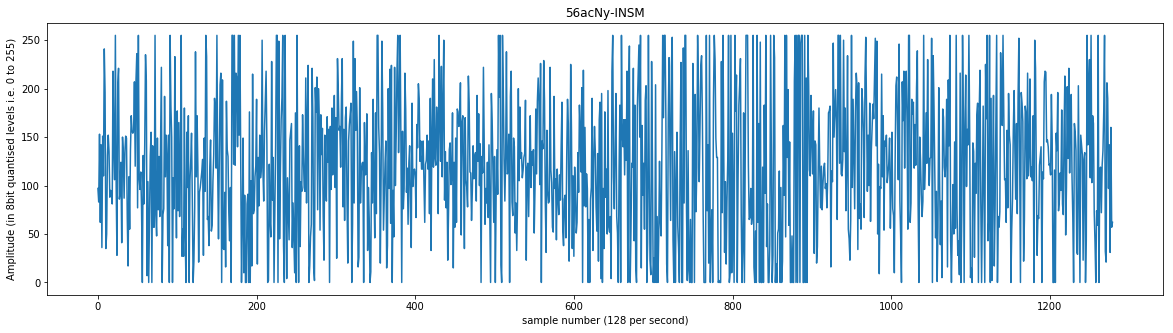

In [18]:
# get the relevant audio clip using above functions
# convert the gibberish to to np.array 
def bytes_to_waveform(vid_id):
    sesh = tf.Session() # create TensorFlow Session

    # get clip information
    clip_info = get_info(vid_id)
    
    
    # for each second of audio
    audio_data = np.array([])
    for second in clip_info["audio"].feature:
                
        # decode the bytes_list
        new = tf.cast(tf.decode_raw(second.bytes_list.value[0],tf.uint8),tf.float32).eval(session=sesh)
        audio_data = np.concatenate((audio_data, new))
        
    # normalise from -1 to 1
    # play the audio aloud
    
    return(audio_data)


# Plot waveform
# YouTubeID = '56qNZpiwRPw'
YouTubeID = '56acNy-INSM'
test = bytes_to_waveform(YouTubeID)
plt.title(YouTubeID)
plt.xlabel('sample number (128 per second)')
plt.ylabel('Amplitude (in 8bit quantised levels i.e. 0 to 255)')
plt.plot(test)
plt.show()

# play the audio
# ipd.Audio(test, rate=1)
librosa.output.write_wav('test.wav', test, 128, norm=True)

# Spectrogram

# D = librosa.amplitude_to_db(np.abs(librosa.stft(test)), ref=np.max)
# librosa.display.specshow(D, y_axis='log')